# Time Series KMeans

In [1]:
import os
import numpy as np
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt

In [2]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score

In [3]:
# -1〜+1の間に規格化 :ToDo
def normalize(score):
    norm = (score-score.min())/(score.max()-score.min()) # 0-1に規格化
    norm = norm * 2
    norm = norm - np.mean(norm, axis=0)
    return norm

In [4]:
# 分類されたクラスタを表示
def show_cluster(tm_kmeans, suptitle, title, n_row=3, n_col=3):
    center = tm_kmeans.cluster_centers_[:,:,0]
    plt.figure(figsize=(15, 10))
    plt.suptitle(suptitle, fontsize=20)
    for i in np.arange(len(center)):
        ax = plt.subplot(n_row, n_col, i+1)
        ax.set_title(f'{title}:{i+1}', fontsize=15)
        ax.plot(center[i])
    plt.tight_layout()
    plt.show()

In [5]:
# 使うデータは1036冊分の小説データの感情スコア値
SCORE_PATH = 'data/all_score_0630.csv'
TARGET_PATH = 'data/target2.csv'

In [6]:
# スコアファイル読み込み
score_df = pd.read_csv(SCORE_PATH, index_col=0)
score_df.head()

,S00,S01,S02,S03,S04,S05,S06,S07,S08,S09,...,S90,S91,S92,S93,S94,S95,S96,S97,S98,S99
13,0.791536,0.737968,0.829343,0.794293,0.724665,0.707668,0.620669,0.607199,0.584499,0.626389,...,0.754139,0.782878,0.784226,0.576965,0.534152,0.601299,0.612696,0.611167,0.664706,0.736535
24,0.749562,0.727724,0.721075,0.648729,0.764811,0.627247,0.634754,0.640822,0.792777,0.844474,...,0.690379,0.640809,0.828280,0.806064,0.754045,0.906671,0.896347,0.869153,0.901117,0.933473
30,0.473785,0.473785,0.652944,0.622040,0.663769,0.799352,0.982744,0.966812,0.851591,0.907304,...,0.101549,0.142406,0.285570,0.270750,0.320434,0.441094,0.464494,0.548101,0.610829,0.517892
41,0.900899,0.952689,1.000000,0.928408,0.802310,0.760143,0.699925,0.759109,0.660739,0.726829,...,0.094422,0.246499,0.291265,0.373439,0.445357,0.450839,0.390509,0.337263,0.402609,0.459209
47,0.742317,0.836033,0.890097,0.911625,0.967501,0.967501,0.972570,0.982321,1.000000,0.929571,...,0.202141,0.256933,0.256933,0.243298,0.175068,0.204548,0.171354,0.173879,0.108680,0.023454


In [7]:
# ターゲットファイル読み込み
target_df = pd.read_csv(TARGET_PATH, index_col=0)
target_df.head(2)

,対象,人物ID,氏名,読み,作品ID,作品名,副題,作品名読み,図書カードURL,テキストファイルURL,テキストファイルパス,スコアファイルパス,備考,length
0,True,374,饗庭 篁村,あえば こうそん,45754,良夜,NaN,りょうや,https://www.aozora.gr.jp/cards/000374/card4575...,https://www.aozora.gr.jp/cards/000374/files/45...,./bunko/cards/000374/files/edit/45754_ruby_236...,./bunko/cards/000374/files/score/45754_ruby_23...,NaN,119.0
1,True,879,芥川 竜之介,あくたがわ りゅうのすけ,73,或敵打の話,NaN,あるかたきうちのはなし,https://www.aozora.gr.jp/cards/000879/card73.html,https://www.aozora.gr.jp/cards/000879/files/73...,./bunko/cards/000879/files/edit/73_ruby_1217.txt,./bunko/cards/000879/files/score/73_ruby_1217.txt,NaN,280.0


In [8]:
# ターゲットファイルとスコアファイルをマージ
df_merge_all = pd.merge(target_df, score_df, left_index=True, right_index=True)
df_merge_all.head(3)

,対象,人物ID,氏名,読み,作品ID,作品名,副題,作品名読み,図書カードURL,テキストファイルURL,...,S90,S91,S92,S93,S94,S95,S96,S97,S98,S99
13,True,879,芥川 竜之介,あくたがわ りゅうのすけ,124,お律と子等と,NaN,おりつとこらと,https://www.aozora.gr.jp/cards/000879/card124....,https://www.aozora.gr.jp/cards/000879/files/12...,...,0.754139,0.782878,0.784226,0.576965,0.534152,0.601299,0.612696,0.611167,0.664706,0.736535
24,True,879,芥川 竜之介,あくたがわ りゅうのすけ,77,奇怪な再会,NaN,きかいなさいかい,https://www.aozora.gr.jp/cards/000879/card77.html,https://www.aozora.gr.jp/cards/000879/files/77...,...,0.690379,0.640809,0.828280,0.806064,0.754045,0.906671,0.896347,0.869153,0.901117,0.933473
30,True,879,芥川 竜之介,あくたがわ りゅうのすけ,38,戯作三昧,NaN,げさくざんまい,https://www.aozora.gr.jp/cards/000879/card38.html,https://www.aozora.gr.jp/cards/000879/files/38...,...,0.101549,0.142406,0.285570,0.270750,0.320434,0.441094,0.464494,0.548101,0.610829,0.517892


In [9]:
# Indexを列として出して，振り直し
df_merge = df_merge_all.reset_index()
df_merge = df_merge.rename(columns={'index': 'TargetID'})
df_merge.head()

,TargetID,対象,人物ID,氏名,読み,作品ID,作品名,副題,作品名読み,図書カードURL,...,S90,S91,S92,S93,S94,S95,S96,S97,S98,S99
0,13,True,879,芥川 竜之介,あくたがわ りゅうのすけ,124,お律と子等と,NaN,おりつとこらと,https://www.aozora.gr.jp/cards/000879/card124....,...,0.754139,0.782878,0.784226,0.576965,0.534152,0.601299,0.612696,0.611167,0.664706,0.736535
1,24,True,879,芥川 竜之介,あくたがわ りゅうのすけ,77,奇怪な再会,NaN,きかいなさいかい,https://www.aozora.gr.jp/cards/000879/card77.html,...,0.690379,0.640809,0.828280,0.806064,0.754045,0.906671,0.896347,0.869153,0.901117,0.933473
2,30,True,879,芥川 竜之介,あくたがわ りゅうのすけ,38,戯作三昧,NaN,げさくざんまい,https://www.aozora.gr.jp/cards/000879/card38.html,...,0.101549,0.142406,0.285570,0.270750,0.320434,0.441094,0.464494,0.548101,0.610829,0.517892
3,41,True,879,芥川 竜之介,あくたがわ りゅうのすけ,59,邪宗門,NaN,じゃしゅうもん,https://www.aozora.gr.jp/cards/000879/card59.html,...,0.094422,0.246499,0.291265,0.373439,0.445357,0.450839,0.390509,0.337263,0.402609,0.459209
4,47,True,879,芥川 竜之介,あくたがわ りゅうのすけ,155,少年,NaN,しょうねん,https://www.aozora.gr.jp/cards/000879/card155....,...,0.202141,0.256933,0.256933,0.243298,0.175068,0.204548,0.171354,0.173879,0.108680,0.023454


In [10]:
# スコアだけ表示してみる
df_merge.loc[:,'S00':]

,S00,S01,S02,S03,S04,S05,S06,S07,S08,S09,...,S90,S91,S92,S93,S94,S95,S96,S97,S98,S99
0,0.791536,0.737968,0.829343,0.794293,0.724665,0.707668,0.620669,0.607199,0.584499,0.626389,...,0.754139,0.782878,0.784226,0.576965,0.534152,0.601299,0.612696,0.611167,0.664706,0.736535
1,0.749562,0.727724,0.721075,0.648729,0.764811,0.627247,0.634754,0.640822,0.792777,0.844474,...,0.690379,0.640809,0.828280,0.806064,0.754045,0.906671,0.896347,0.869153,0.901117,0.933473
2,0.473785,0.473785,0.652944,0.622040,0.663769,0.799352,0.982744,0.966812,0.851591,0.907304,...,0.101549,0.142406,0.285570,0.270750,0.320434,0.441094,0.464494,0.548101,0.610829,0.517892
3,0.900899,0.952689,1.000000,0.928408,0.802310,0.760143,0.699925,0.759109,0.660739,0.726829,...,0.094422,0.246499,0.291265,0.373439,0.445357,0.450839,0.390509,0.337263,0.402609,0.459209
4,0.742317,0.836033,0.890097,0.911625,0.967501,0.967501,0.972570,0.982321,1.000000,0.929571,...,0.202141,0.256933,0.256933,0.243298,0.175068,0.204548,0.171354,0.173879,0.108680,0.023454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031,1.000000,0.886321,0.760418,0.683147,0.649745,0.606923,0.571151,0.517130,0.492479,0.494035,...,0.180267,0.172682,0.146108,0.091107,0.070645,0.042570,0.032390,0.094500,0.142480,0.098496
1032,0.928336,1.000000,0.946976,0.868300,0.888023,0.706569,0.560303,0.661318,0.782652,0.888690,...,0.472828,0.545340,0.500948,0.563695,0.563695,0.697739,0.767883,0.759698,0.974234,0.763724
1033,1.000000,0.909603,0.793596,0.745868,0.727928,0.758194,0.740752,0.763606,0.817574,0.829033,...,0.687817,0.752808,0.738397,0.750526,0.830493,0.896725,0.919508,0.899834,0.873144,0.925176
1034,0.528431,0.438392,0.438334,0.539294,0.604325,0.652928,0.757941,0.918232,0.951555,0.909684,...,0.440108,0.449598,0.485174,0.381715,0.325619,0.357203,0.409554,0.360593,0.315495,0.401312


In [11]:
scores = df_merge.loc[:,'S00':].to_numpy()
# scores = score_df.to_numpy()

In [12]:
# 平均値を０にしておく(-1〜1の間に規格化)
A = normalize(scores)
# A = scores - scores.mean(axis=0)
A.shape, np.min(A), np.max(A), np.mean(A)

((1036, 100), -1.1071332471188664, 1.0698986010803475, -4.020807710804621e-18)

## metric:euclidean

In [45]:
km1 = TimeSeriesKMeans(n_clusters=9, metric='euclidean', random_state=0)
km1.fit(A)

TimeSeriesKMeans(n_clusters=9, random_state=0)

In [46]:
km1.cluster_centers_.shape

(9, 100, 1)

In [47]:
center1 = km1.cluster_centers_[:,:,0]
center1.shape

(9, 100)

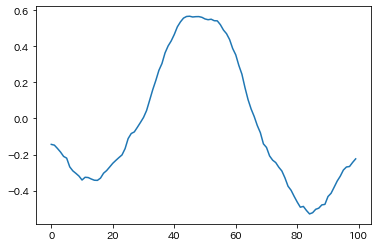

In [48]:
plt.plot(center1[2])

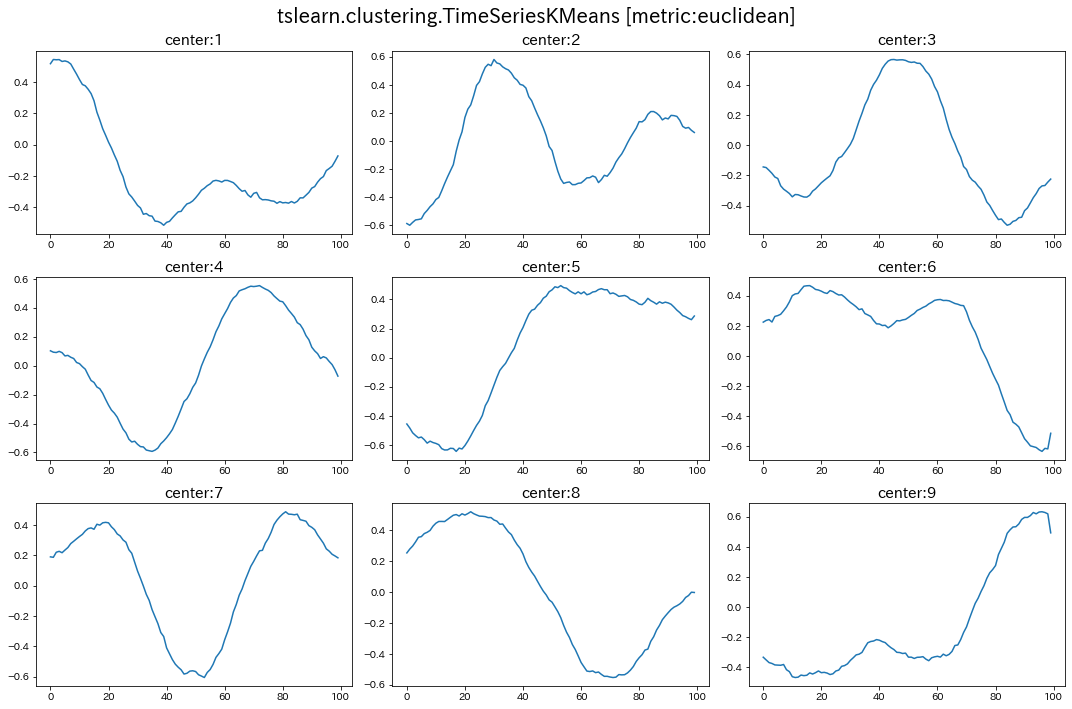

In [50]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:euclidean]'
show_cluster(km1, suptitle, 'center')

## metric:dtw

In [51]:
km2 = TimeSeriesKMeans(n_clusters=9, metric='dtw', random_state=0)
km2.fit(A)

TimeSeriesKMeans(metric='dtw', n_clusters=9, random_state=0)

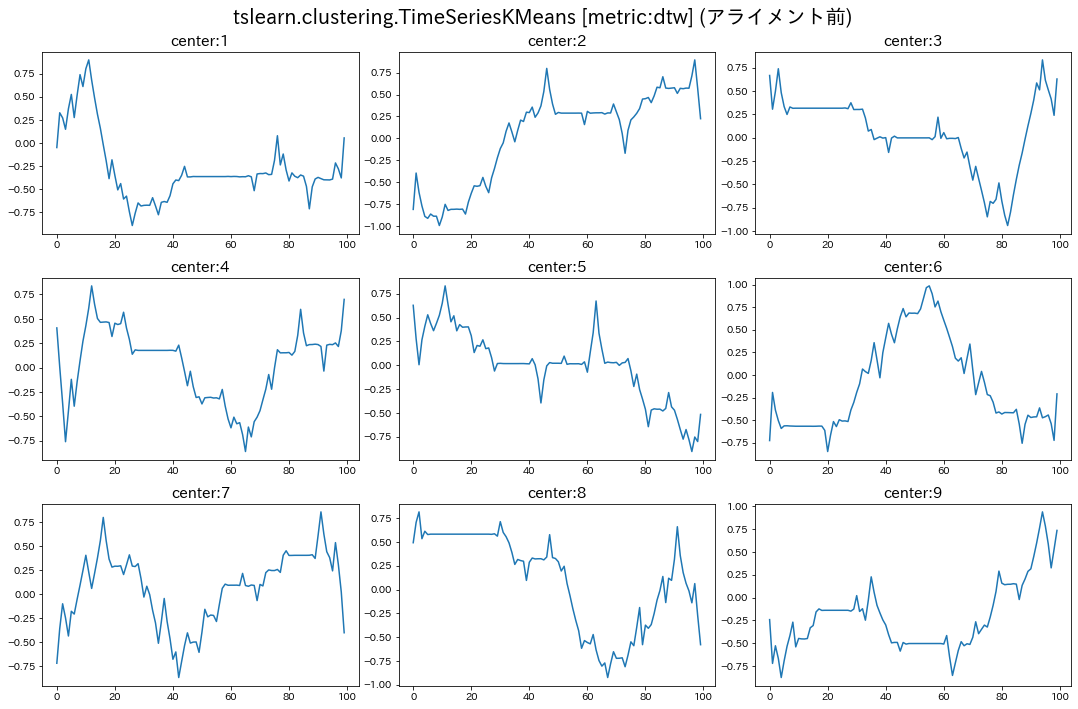

In [52]:
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw] (アライメント前)'
show_cluster(km2, suptitle, 'center')

In [53]:
np.unique(km2.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [56]:
km2_pred = km2.predict(A)

/usr/local/lib/python3.8/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1036 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [54]:
distances = km2.transform(A)
distances.shape

/usr/local/lib/python3.8/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1036 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


(1036, 9)

In [55]:
np.where(km2.labels_==0)[0].shape

(91,)

In [57]:
keys = np.where(km2.labels_==0)[0]
values = distances[km2.labels_==0][:, 0]
distance_dicts = {k: v for k, v in zip(keys, values)}
distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
# np.where(km2.labels_==0)[0], distances[km2.labels_==0][:, 0]

In [58]:
distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
print(distance_dicts_sort_key[:20])

[715, 355, 607, 436, 864, 200, 314, 633, 293, 960, 861, 153, 1034, 36, 964, 654, 663, 509, 487, 925]


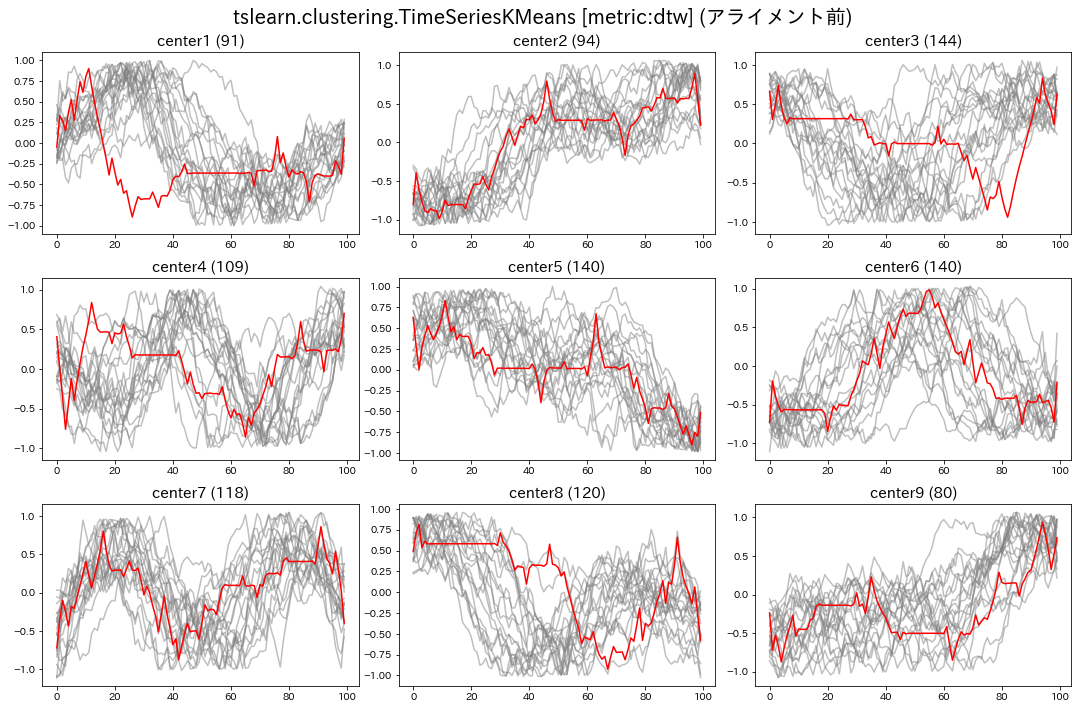

In [59]:
n_clusters = len(np.unique(km2.labels_)) 
disp_num = 20
plt.figure(figsize=(15, 10))
plt.suptitle('tslearn.clustering.TimeSeriesKMeans [metric:dtw] (アライメント前)', fontsize=20)
for label in range(n_clusters):
    keys = np.where(km2.labels_==label)[0]
    values = distances[km2.labels_==label][:, label]
    distance_dicts = {k: v for k, v in zip(keys, values)}
    distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
    distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
    # print(label, distance_dicts_sort_key[:20])
    # グラフ表示
    cell = label + 1
    ax = plt.subplot(3, 3, cell)
    count = len(distance_dicts_sort_key)
    ax.set_title(f'center{cell} ({count})', fontsize=15)    
    for idx in distance_dicts_sort_key[:disp_num]:
        ax.plot(A[idx], alpha=.5, c='gray')
    plt.plot(km2.cluster_centers_[label].ravel(), c='red')
plt.tight_layout()
plt.show()

## metric:softdtw

In [61]:
km3 = TimeSeriesKMeans(n_clusters=9, metric='softdtw', random_state=0)
km3.fit(A)

TimeSeriesKMeans(metric='softdtw', n_clusters=9, random_state=0)

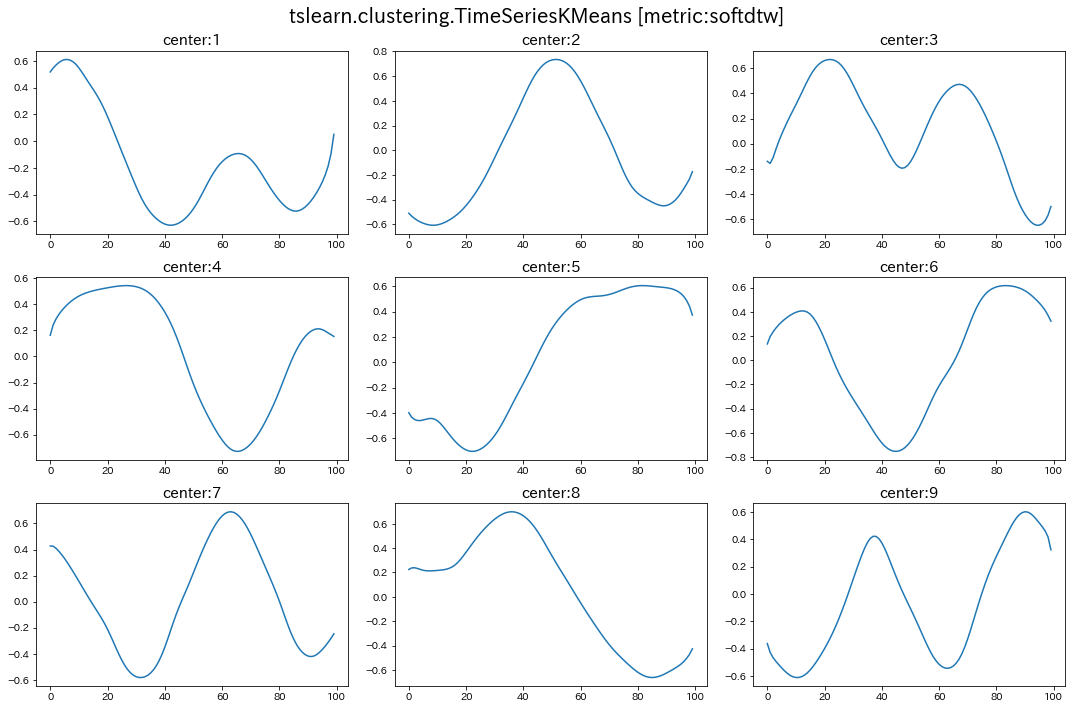

In [62]:
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:softdtw]'
show_cluster(km3, suptitle, 'center')

## エルボー法

In [15]:
distortions = []
tskms = []
for n in range(1, 11):
    print('n_clusters:', n)
    km = TimeSeriesKMeans(n_clusters=n, metric='dtw', random_state=0)
    km.fit(A)
    tskms.append(km)
    distortions.append(km.inertia_)

n_clusters: 1
n_clusters: 2
n_clusters: 3
n_clusters: 4
n_clusters: 5
n_clusters: 6
n_clusters: 7
n_clusters: 8
n_clusters: 9
n_clusters: 10


In [27]:
# 作成したモデルを保存しておく
for i in range(len(tskms)):
    # print(i, f'data/tskm_cluster{i+1}.hdf5')
    file_path = f'data/tskm_cluster{i+1}.hdf5'
    if os.path.isfile(file_path):
        os.remove(file_path)
    tskms[i].to_hdf5(file_path)

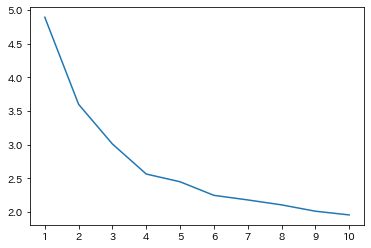

In [16]:
plt.plot(distortions)
plt.xticks(range(10), range(1,11))
plt.show()

## シルエット法

In [13]:
# 保存されたファイルからロードする場合は以下を実施
tskms = []
for n in range(10):
    file_path = f'data/tskm_cluster{n+1}.hdf5'
    if os.path.isfile(file_path):
        print(f'Load: tskms[{n}]=',file_path, )
        tskms.append(TimeSeriesKMeans.from_hdf5(file_path))
    else:
        print('Skip: ',file_path)

Load: tskms[0]= data/tskm_cluster1.hdf5
Load: tskms[1]= data/tskm_cluster2.hdf5
Load: tskms[2]= data/tskm_cluster3.hdf5
Load: tskms[3]= data/tskm_cluster4.hdf5
Load: tskms[4]= data/tskm_cluster5.hdf5
Load: tskms[5]= data/tskm_cluster6.hdf5
Load: tskms[6]= data/tskm_cluster7.hdf5
Load: tskms[7]= data/tskm_cluster8.hdf5
Load: tskms[8]= data/tskm_cluster9.hdf5
Load: tskms[9]= data/tskm_cluster10.hdf5


In [41]:
silhouette_score(A, tskms[3].labels_, 'dtw')

0.22072428090707782

In [42]:
silhouette_score(A, tskms[5].labels_, 'dtw')

0.16626760725861936

In [14]:
silhouette_scores = []
for n in range(1, 10):
    print(f'calc.. silhouette score [cluster{n+1}]')
    ss = silhouette_score(A, tskms[n].labels_, 'dtw')
    silhouette_scores.append(ss)
    print(f'silhouette score [cluster{n+1}]: {ss}')

calc.. silhouette score [cluster2]


silhouette score [cluster2]: 0.2886742940088376
calc.. silhouette score [cluster3]
silhouette score [cluster3]: 0.2509953803568257
calc.. silhouette score [cluster4]
silhouette score [cluster4]: 0.22072428090707782
calc.. silhouette score [cluster5]
silhouette score [cluster5]: 0.16544602328564462
calc.. silhouette score [cluster6]
silhouette score [cluster6]: 0.16626760725861936
calc.. silhouette score [cluster7]
silhouette score [cluster7]: 0.17341160984864082
calc.. silhouette score [cluster8]
silhouette score [cluster8]: 0.1522276260254182
calc.. silhouette score [cluster9]
silhouette score [cluster9]: 0.13980725434015503
calc.. silhouette score [cluster10]
silhouette score [cluster10]: 0.13247826449902295


In [25]:
for i in range(len(silhouette_scores)):
    print(f'silhouette score [cluster{i+2}]: {round(silhouette_scores[i],3)}')

silhouette score [cluster2]: 0.289
silhouette score [cluster3]: 0.251
silhouette score [cluster4]: 0.221
silhouette score [cluster5]: 0.165
silhouette score [cluster6]: 0.166
silhouette score [cluster7]: 0.173
silhouette score [cluster8]: 0.152
silhouette score [cluster9]: 0.14
silhouette score [cluster10]: 0.132


## クラスタ数:4

In [66]:
# クラスタ数:4で実施
km4 = TimeSeriesKMeans(n_clusters=4, metric='dtw', random_state=0)
km4.fit(A)
distances = km4.transform(A)

/usr/local/lib/python3.8/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1036 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


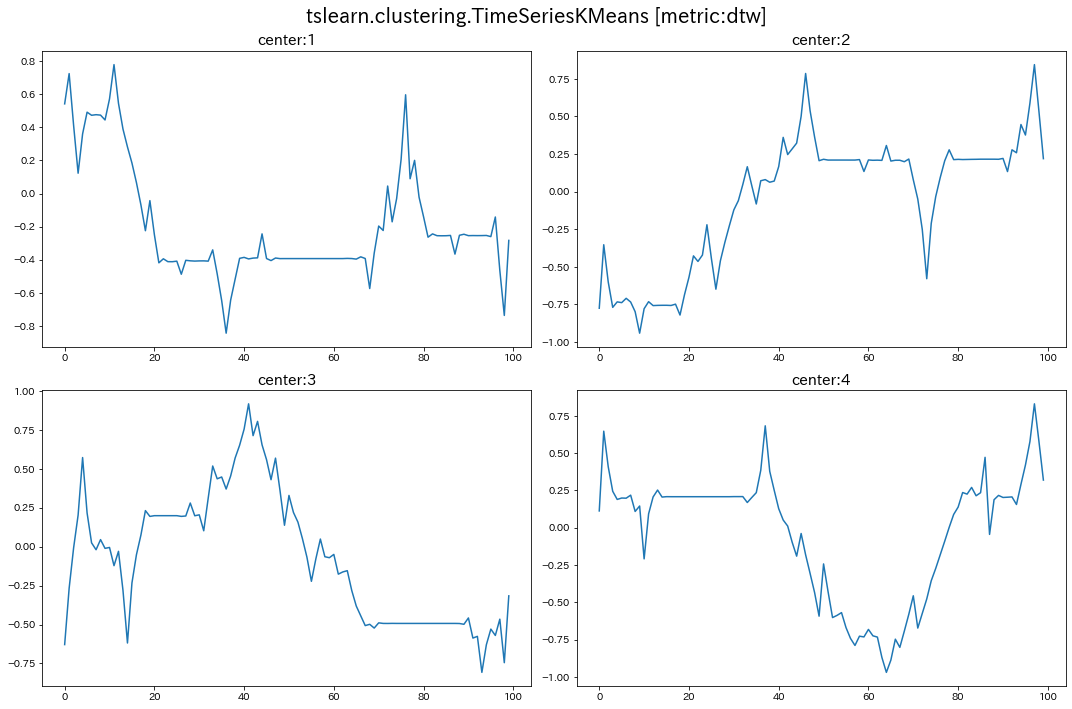

In [67]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw]'
show_cluster(km4, suptitle, 'center', 2, 2)

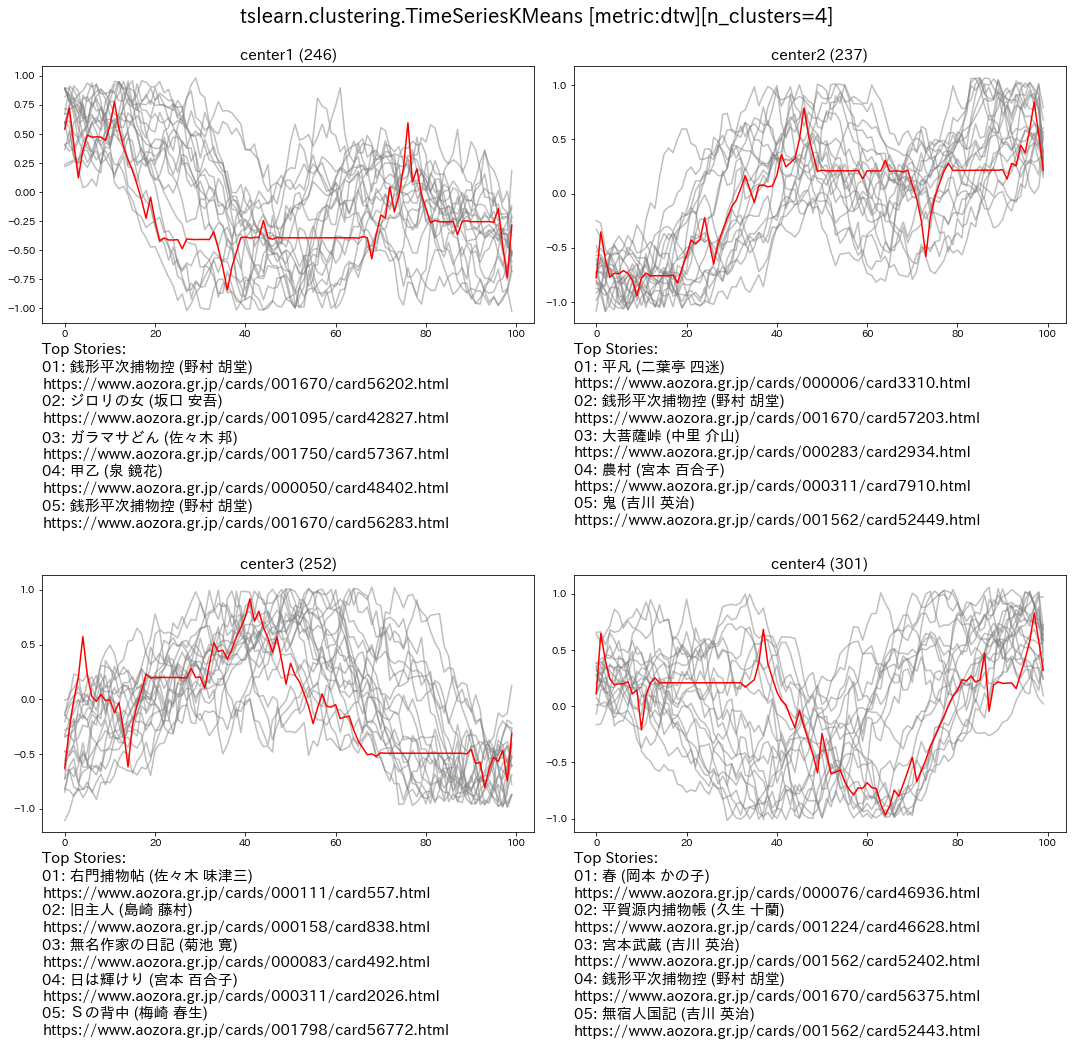

In [149]:
n_clusters = len(np.unique(km4.labels_)) 
disp_num = 20
label_num = 5
plt.figure(figsize=(15, 15))
plt.suptitle('tslearn.clustering.TimeSeriesKMeans [metric:dtw][n_clusters=4]', fontsize=20)
for label in range(n_clusters):
    keys = np.where(km4.labels_==label)[0]
    values = distances[km4.labels_==label][:, label]
    distance_dicts = {k: v for k, v in zip(keys, values)}
    distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
    distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
    # print(label, distance_dicts_sort_key[:20])
    # グラフ表示
    cell = label + 1
    ax = plt.subplot(2, 2, cell)
    count = len(distance_dicts_sort_key)
    top_stories = []
    ax.set_title(f'center{cell} ({count})', fontsize=15)
    for idx in distance_dicts_sort_key[:disp_num]:
        ax.plot(A[idx], alpha=.5, c='gray')
        author = df_merge.iloc[idx].loc['氏名']
        novel = df_merge.iloc[idx].loc['作品名']
        url = df_merge.iloc[idx].loc['図書カードURL']
        top_stories.append(f'{novel} ({author})\n{url}')
    xlabel = 'Top Stories:\n'
    for i in range(label_num):
        xlabel = xlabel + f'{str(i+1).zfill(2)}: {top_stories[i]}\n'
    ax.set_xlabel(xlabel, loc='left', fontsize=15)
    # ax.set_xlabel('\n'.join(top_stories[:5]), loc='left', fontsize=15)
    plt.plot(km4.cluster_centers_[label].ravel(), c='red')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## クラスタ数:6

In [150]:
# クラスタ数:6で実施
km6 = TimeSeriesKMeans(n_clusters=6, metric='dtw', random_state=0)
km6.fit(A)
distances6 = km6.transform(A)

/usr/local/lib/python3.8/dist-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1036 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


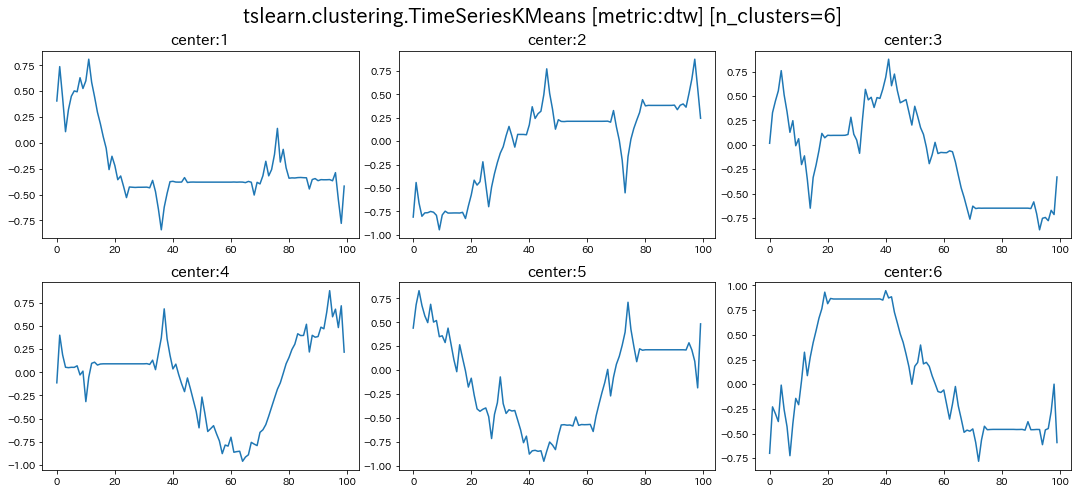

In [152]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw] [n_clusters=6]'
show_cluster(km6, suptitle, 'center')

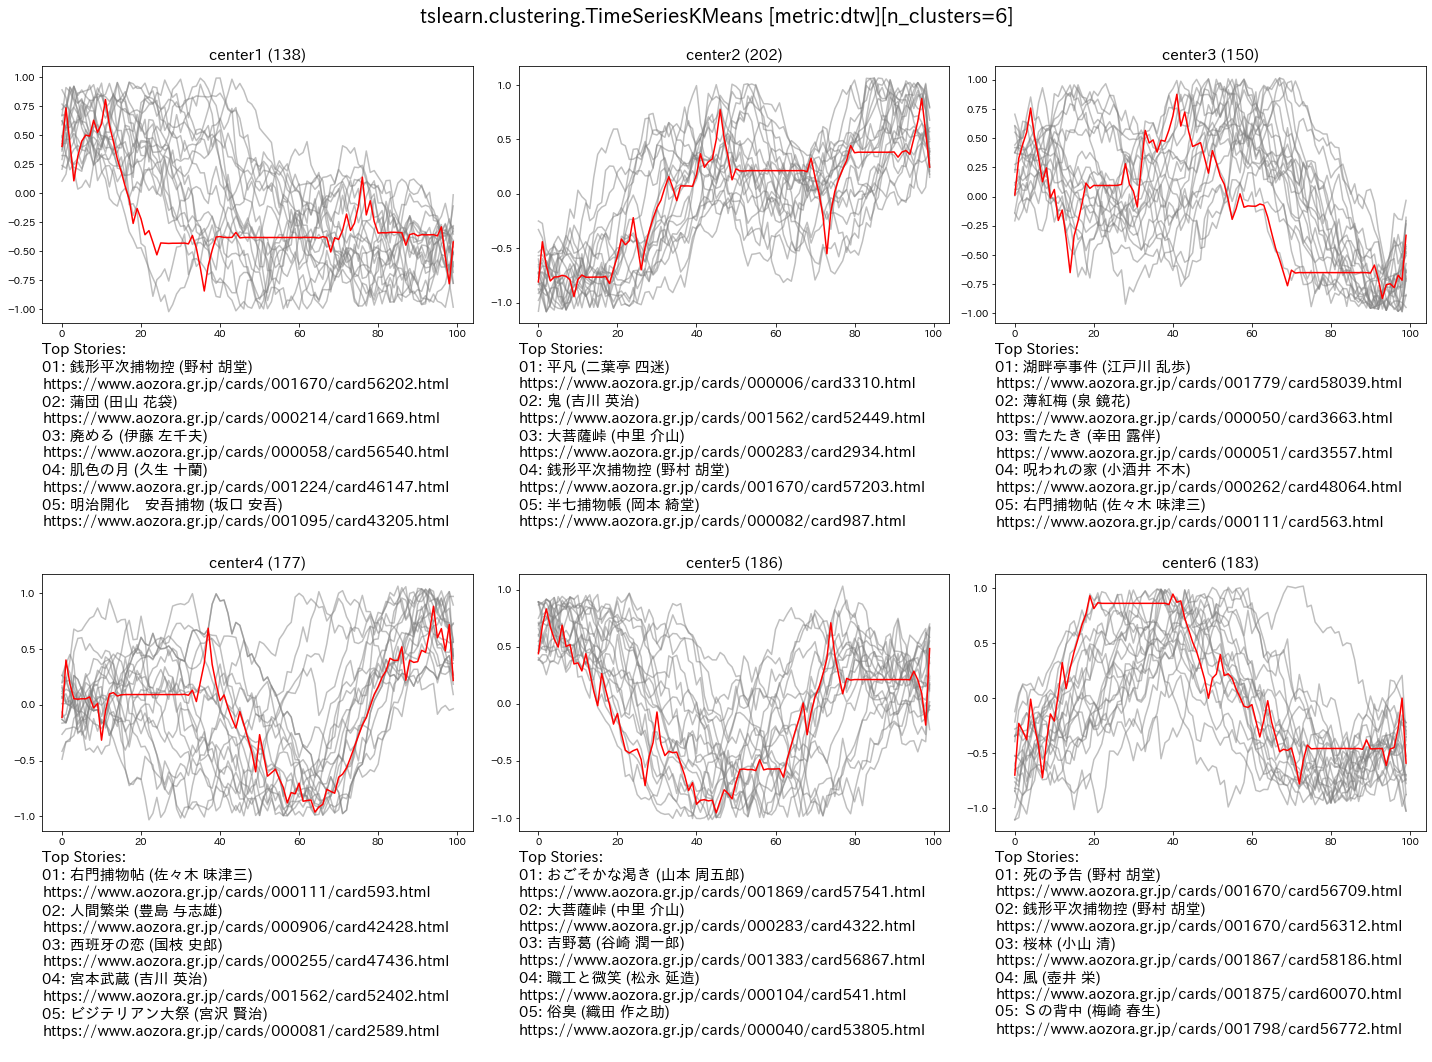

In [156]:
n_clusters = len(np.unique(km6.labels_)) 
disp_num = 20
label_num = 5
plt.figure(figsize=(20, 15))
plt.suptitle('tslearn.clustering.TimeSeriesKMeans [metric:dtw][n_clusters=6]', fontsize=20)
for label in range(n_clusters):
    keys = np.where(km6.labels_==label)[0]
    values = distances6[km6.labels_==label][:, label]
    distance_dicts = {k: v for k, v in zip(keys, values)}
    distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
    distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
    # print(label, distance_dicts_sort_key[:20])
    # グラフ表示
    cell = label + 1
    ax = plt.subplot(2, 3, cell)
    count = len(distance_dicts_sort_key)
    top_stories = []
    ax.set_title(f'center{cell} ({count})', fontsize=15)
    for idx in distance_dicts_sort_key[:disp_num]:
        ax.plot(A[idx], alpha=.5, c='gray')
        author = df_merge.iloc[idx].loc['氏名']
        novel = df_merge.iloc[idx].loc['作品名']
        url = df_merge.iloc[idx].loc['図書カードURL']
        top_stories.append(f'{novel} ({author})\n{url}')
    xlabel = 'Top Stories:\n'
    for i in range(label_num):
        xlabel = xlabel + f'{str(i+1).zfill(2)}: {top_stories[i]}\n'
    ax.set_xlabel(xlabel, loc='left', fontsize=15)
    # ax.set_xlabel('\n'.join(top_stories[:5]), loc='left', fontsize=15)
    plt.plot(km6.cluster_centers_[label].ravel(), c='red')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()